# 割引クーポンキャンペーンの効果最大化

## 導入

- **目的：割引クーポンを同封したDMを送信し，より多くの会員へ来店してもらう**
     
     
- DMのパターン
    1. セールのチラシのみ
    2. セールのチラシと1000円のクーポン
    3. セールのチラシと2000円のクーポン
    
    
- 制約
    - 予算の制約
        - 100万円
        - 来店しても何も買わない可能性があるので，来店時の消費額の期待値を予算とする
    - 送付率の制約
        - 来店傾向をグループ化したセグメントに属する人数の10％に送付
            - 次回以降の割引クーポンキャンペーンで利用する来店率のデータを一定数取得するため

## データ理解

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
import pulp

%matplotlib inline

会員データ

In [3]:
df_customer = pd.read_csv('data/4.coupon/customers.csv')
print(df_customer.shape)
df_customer.head()

(5000, 3)


,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0


In [4]:
df_customer.dtypes

customer_id     int64
age_cat        object
freq_cat       object
dtype: object

|カラム名|名称|データの説明|
|---|---|---|
|customer_id|会員ID|1~5,000の間でユニークな整数値をとる|
|age_cat|年齢区分||
|freq_cat|昨年度来店回数区分||

可視化してみる

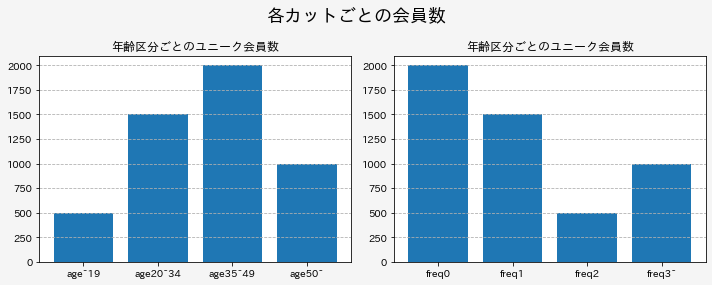

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4), facecolor='whitesmoke')
# 年齢区分ごと ... 棒グラフの横軸が勝手にソートされるのでめんどい処理が必要
tmp = df_customer.groupby('age_cat').agg({'customer_id': 'nunique'})
tmp['tmp'] = tmp.index.map({'age~19':0, 'age20~34': 1, 'age35~49': 2, 'age50~': 3})
tmp = tmp.sort_values('tmp')
axes[0].bar(tmp.index, tmp['customer_id'])
axes[0].set_title('年齢区分ごとのユニーク会員数')
axes[0].grid(axis='y', ls='--')
# 来店数区分ごと ... freqはソートされてもOK
tmp = df_customer.groupby('freq_cat').agg({'customer_id': 'nunique'})
axes[1].bar(tmp.index, tmp['customer_id'])
axes[1].set_title('昨年度来店回数区分ごとのユニーク会員数')
axes[1].set_title('年齢区分ごとのユニーク会員数')
axes[1].grid(axis='y', ls='--')

fig.suptitle('各カットごとの会員数', size=18)
fig.show()
plt.tight_layout()

freq_cat,freq0,freq1,freq2,freq3~
age_cat,,,,
age20~34,600,450,150,300
age35~49,800,600,200,400
age50~,400,300,100,200
age~19,200,150,50,100


<AxesSubplot:xlabel='freq_cat', ylabel='age_cat'>

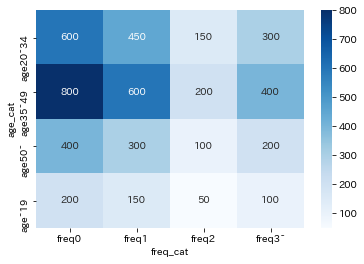

In [6]:
# クロス集計
df_pivot_customer = pd.pivot_table(
    data=df_customer,
    values='customer_id',
    columns='freq_cat',
    index='age_cat',
    aggfunc='count')
display(df_pivot_customer)
# の可視化
sns.heatmap(df_pivot_customer, annot=True, fmt='d', cmap='Blues')

In [7]:
# セグメントごとの来店率データ
# 昨年度の年齢と昨年度来店回数区分でセグメント分け
# ついでにセグメントごとの客数もJOIN
df_proba = pd.read_csv('data/4.coupon/visit_probability.csv')
print(df_proba.shape)
n_customer_per_seg = df_customer.groupby(['age_cat', 'freq_cat']).agg({'customer_id': 'nunique'}).reset_index().rename(columns={'customer_id': 'n_cusotmer'})
pd.merge(df_proba, n_customer_per_seg, on=['age_cat', 'freq_cat'])

(16, 6)


,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3,n_cusotmer
0,age~19,freq0,1,0.07,0.12,0.29,200
1,age~19,freq1,2,0.21,0.30,0.58,150
2,age~19,freq2,3,0.28,0.39,0.74,50
3,age~19,freq3~,4,0.35,0.45,0.77,100
4,age20~34,freq0,5,0.11,0.17,0.37,600
5,age20~34,freq1,6,0.32,0.43,0.72,450
6,age20~34,freq2,7,0.42,0.55,0.93,150
7,age20~34,freq3~,8,0.52,0.63,0.94,300
8,age35~49,freq0,9,0.08,0.14,0.33,800
9,age35~49,freq1,10,0.25,0.35,0.67,600


- `age_cat` : 年齢区分
- `freq_cat` : 昨年度来店回数区分
- `segment_id` : セグメントID．年齢区分と昨年度来店回数区分の組み合わせによる会員のセグメント
- `prob_dm1` : パターン1来店率．当該セグメントにセールのチラシのみのDMを送付したときの来店率
- `prob_dm2` : パターン2来店率．セールチラシと1,000円のクーポンのDMを送付したときの来店率
- `prob_dm3` : パターン3来店率．セールチラシと2,000円のクーポンのDMを送付したときの来店率

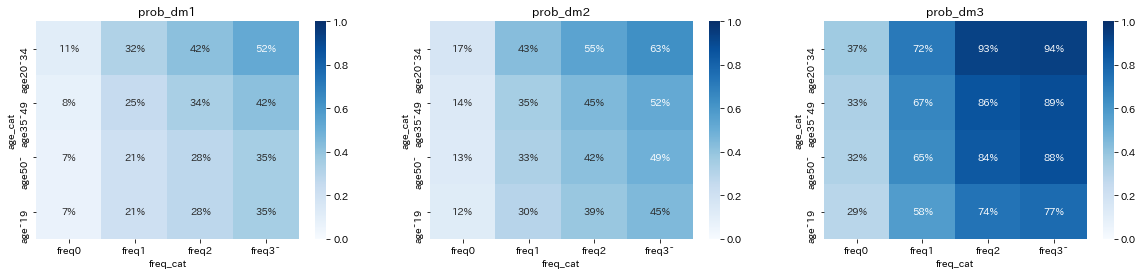

In [8]:
# 各DM送付パターンの来店率をクロス集計
fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,4))
for dm_ptn, ax in zip(['prob_dm1','prob_dm2','prob_dm3'], axes):
    df_piv = pd.pivot_table(
        data=df_proba,
        values=dm_ptn,
        columns='freq_cat',
        index='age_cat')
    sns.heatmap(df_piv, vmin=0, vmax=1, annot=True, fmt='.0%', cmap='Blues', ax=ax)
    ax.set_title(dm_ptn)
fig.show()

## モデリング 

1. 会員個別送付モデル
    - 会員単位でDMを送るか否か(離散最適化)
2. セグメント送付モデル
    - セグメントに対して各パターンのDMをどの程度送付するかを決める(連続最適化)

### 会員個別送付モデル(離散最適化)

In [9]:
problem = pulp.LpProblem(name='DiscountCouponProblem1', sense=pulp.LpMaximize)

- **要件1：各会員に対してどのパターンのDMを送付するかを決定**
    - 会員IDリストを$I$
    - DMのパターンのリスト$M \in \{ 1,2,3 \}$ 
        1. セールチラチのみ
        2. セールチラシと1000円のクーポン
        3. セールチラシと2000円のクーポン
    - 決定変数 $x_{im}$：会員$i \in I$に対してDMのパターン$m \in M$を送付する場合に1，そうでない場合に0を取る

In [10]:
# 要件1：各会員に対してどのパターンのDMを送付するかを決定

# I : 会員IDのリスト
I = df_customer['customer_id'].to_list()
# M : DMパターンのリスト
M = [1, 2, 3]
# x_im : 決定変数, 会員iにパターンmのDMを送付
x_im = {}
for i in I:
    for m in M:
        x_im[i,m] = pulp.LpVariable(name=f"xim({i},{m})", cat='Binary')

print(len(I))
print(len(M))
print(len(x_im))

5000
3
15000


- **要件2：各会員に対して送付するDMはいずれか1パターン**
    - $\sum_{m \in M} x_{im} = 1$

In [11]:
# 要件2：各会員に対して送付するDMはいずれか1パターン

for i in I:
    problem.addConstraint(pulp.lpSum(x_im[i,m] for m in M) == 1)

- **要件3：クーポン付与による来客増加数を最大化**
    - $P_{im} \in [0,1] \ (i \in I, m \in M)$：会員$i \in I$に対してパターン$m \in M$のDMを送付したときの来店率
        - これは`df_proba`に入っている昨年度のセグメントごとの来店率
    - $\sum_{i \in I} \sum_{m \in M} (P_{im} - P_{i1}) \ x_{im}$

In [12]:
# 要件3：クーポン付与による来客増加数を最大化

In [13]:
# P_imの定義

In [14]:
df_customer_proba = pd.merge(df_customer, df_proba, on=['age_cat', 'freq_cat'])
print(df_customer_proba.shape)
df_customer_proba.head()

(5000, 7)


,customer_id,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,1,age20~34,freq2,7,0.42,0.55,0.93
1,199,age20~34,freq2,7,0.42,0.55,0.93
2,200,age20~34,freq2,7,0.42,0.55,0.93
3,255,age20~34,freq2,7,0.42,0.55,0.93
4,269,age20~34,freq2,7,0.42,0.55,0.93


In [15]:
# IDとDMパターンについて縦持ちに変換しておく
df_customer_proba_ver = df_customer_proba\
    .rename(columns={'prob_dm1': 1, 'prob_dm2': 2, 'prob_dm3': 3})\
    .melt(id_vars=['customer_id'], value_vars=[1,2,3], var_name='dm', value_name='prob')
print(df_customer_proba_ver.shape)
df_customer_proba_ver.sort_values('customer_id').head()

(15000, 3)


,customer_id,dm,prob
0,1,1,0.42
5000,1,2,0.55
10000,1,3,0.93
150,2,1,0.08
10150,2,3,0.33


In [16]:
P_im = df_customer_proba_ver.set_index(['customer_id', 'dm'])['prob'].to_dict()
print(len(P_im))

15000


In [17]:
problem.setObjective( pulp.lpSum((P_im[i,m] - P_im[i,1])*x_im[i,m] for i in I for m in [2,3]))

- **要件4：会員の予算消費期待値の合計は100万円以下**
    - $C_m \in \{0, 1000, 2000\}$：DMのパターン$m\in M$に付与するクーポンの金額(定数)
    - $\sum_{i \in I} \sum_{m \in M} \ C_m P_{im} x_{im} \le 1000000$

In [18]:
# 要件4：会員の予算消費期待値の合計は100万円以下

C_m = {1:0, 2:1000, 3:2000}

problem.addConstraint( pulp.lpSum(C_m[m] * P_im[i,m] * x_im[i,m] for i in I for m in [2,3]) <= 1000000 )

- **要件5：各パターンのDMをそれぞれのセグメントに属する会員10%以上に送付**
    - $S$：年齢区分と昨年度来店回数区分によるセグメントのリスト
    - $N_s$：セグメント$s \in S$に属する会員数
    - $Z_{is} \in \{0, 1\}$：会員$i\in I$がセグメント$s \in S$に属する場合1，そうでない場合0
    - $\sum_{i \in I} \ Z_{is} x_{im} \ge 0.1 \cdot N_s \ \ (s \in S, m \in M)$

In [19]:
# S : セグメントリスト
S = df_proba['segment_id'].to_list()
print(len(S))
# N_s : 各セグメントに属する会員数
N_s = df_customer_proba.groupby(['segment_id'])['customer_id'].count().to_dict()
print(N_s)
# S_i : 会員をキーとして属するセグメントを返す辞書
S_i = df_customer_proba.set_index('customer_id')['segment_id'].to_dict()

16
{1: 200, 2: 150, 3: 50, 4: 100, 5: 600, 6: 450, 7: 150, 8: 300, 9: 800, 10: 600, 11: 200, 12: 400, 13: 400, 14: 300, 15: 100, 16: 200}


In [20]:
# 各パターンのDMをそれぞれのセグメントに属する会員の10％以上送付
for s in S:
    for m in M:
        problem.addConstraint(
            pulp.lpSum(x_im[i,m] for i in I if S_i[i] == s) >= 0.1 * N_s[s])

In [21]:
import time
start = time.time()
status = problem.solve()
end = time.time()

print(f"status : {pulp.LpStatus[status]}")
print(f"目的関数値 : {pulp.value(problem.objective):.4f}")
print(f"計算時間 : {(end - start):.3f}秒")

status : Optimal
目的関数値 : 326.0900
計算時間 : 3.446秒


- 目的関数値は`326`
    - 全員にクーポン無しのDMを送るときよりも326人増加する
    - 来店数1人あたりの獲得費用で換算すると100万円/326人より約3067円で1会員の来客を増やすことができると評価できる

In [28]:
df_send_dm = pd.DataFrame(
    [[x_im[i,m].value() for m in M] for i in I],
    columns = ['send_dm1', 'send_dm2', 'send_dm3'])
print(df_send_dm.shape)
df_send_dm.head()

(5000, 3)


,send_dm1,send_dm2,send_dm3
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0


In [30]:
df_customer_send = pd.concat([df_customer[['customer_id','age_cat','freq_cat']], df_send_dm], axis=1)
print(df_customer_send.shape)
df_customer_send.head(10)

(5000, 6)


,customer_id,age_cat,freq_cat,send_dm1,send_dm2,send_dm3
0,1,age20~34,freq2,0.0,1.0,0.0
1,2,age35~49,freq0,0.0,1.0,0.0
2,3,age35~49,freq0,0.0,1.0,0.0
3,4,age~19,freq0,0.0,1.0,0.0
4,5,age35~49,freq0,0.0,1.0,0.0
5,6,age20~34,freq1,1.0,0.0,0.0
6,7,age~19,freq1,1.0,0.0,0.0
7,8,age~19,freq0,0.0,1.0,0.0
8,9,age35~49,freq0,1.0,0.0,0.0
9,10,age20~34,freq1,1.0,0.0,0.0


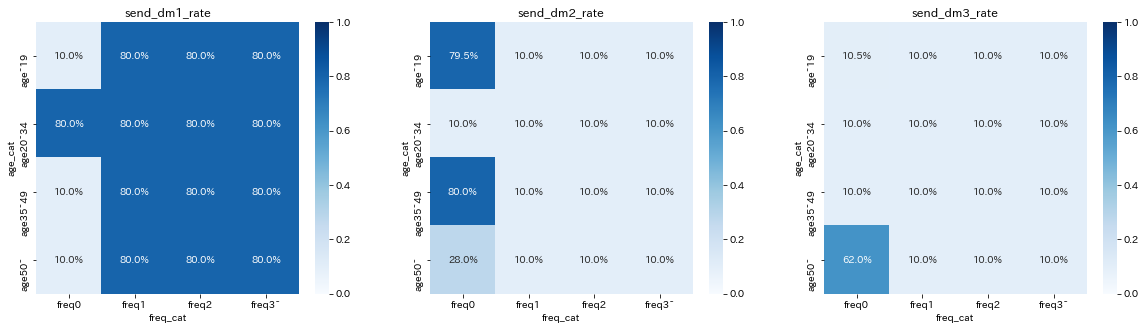

In [38]:
# 各セグメントに対するDMの送付率を可視化

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
for i, dm_ptn in enumerate(['send_dm1', 'send_dm2', 'send_dm3']):
    df_pivot = pd.pivot_table(
        data=df_customer_send,
        values=dm_ptn,
        columns='freq_cat', index='age_cat',
        aggfunc='mean').reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(df_pivot, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=1, ax=axes[i])
    axes[i].set_title(f"{dm_ptn}_rate")
fig.show()

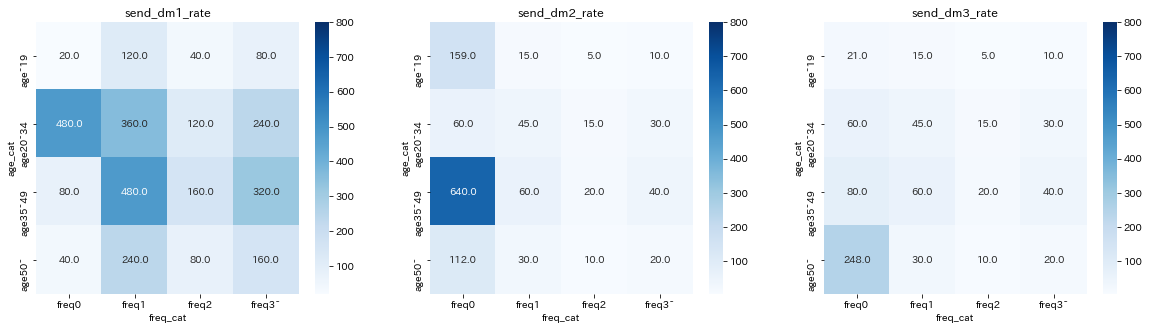

In [41]:
# 各セグメントに対するDMの送付数を可視化

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
for i, dm_ptn in enumerate(['send_dm1', 'send_dm2', 'send_dm3']):
    df_pivot = pd.pivot_table(
        data=df_customer_send,
        values=dm_ptn,
        columns='freq_cat', index='age_cat',
        aggfunc='sum').reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(df_pivot, annot=True, cmap='Blues', fmt='.1f', vmax=800, ax=axes[i])
    axes[i].set_title(f"{dm_ptn}_rate")
fig.show()

- 全てのセグメントに対して各パターンのDMが10％以上は送付されていることが確認できる
- 年齢区分50歳以上で昨年度来店回数が0回のセグメントに2000円のクーポンを送付している数が多い
- セグメント別にモデリングした後，再度考察を行う

### セグメント送付モデル(連続最適化)
- 各セグメントに所属する会員数のうち何％に送付するかを最適化する連続最適化を行う

- 会員の来店率はセグメントごとにしか見積もっていないので，個別会員にDM送付パターンを割り当てる必要はないのでは？
    - 同じセグメントごとに属する会員であれば，どの会員に送付しても来店率は買わない，という暗黙の前提のもとでモデリング行なっていた
    - そうであれば，各セグメントに所属する会員数に対してどの程度の比率でDMを送付するかを最適化するだけで良いはず

- 決定変数 $x_{sm} \in [0,1] \ (s \in S, m \in M)$：セグメント$s \in S$に対するDMの送付パターン$m \in M$の送付率
- 各セグメントごとのDM送付率の総和は1(比率の要請) -> $\sum_{M} x_{sm} = 1 \ (s \in S)$
- クーポン付与による来客数増加を最大化
    - $P_{sm}\in [0,1]$ : セグメントsに対してDMパターンmを送付したときの来店率
    - $N_s$ : セグメントsに属する会員数
    - $\sum_{S}\sum_{M} N_s \ (P_{sm} - P_{s1}) \ x_{sm}$
- 予算消費期待値の合計は100万円以下
    - $\sum_{S} \sum_{M} C_{m} N_{s} P_{sm} x_{sm} \le 1000000$

In [61]:
# 数理モデルインスタンス
problem = pulp.LpProblem(name='DiscountCuoponProblem2', sense=pulp.LpMaximize)

S = df_proba['segment_id'].unique().tolist()
M = [1,2,3]
""" 決定変数 x_sm """
x_sm = {}
for s in S:
    for m in M:
        x_sm[s,m] = pulp.LpVariable(name=f"x_sm({s},{m})", lowBound=0, upBound=1, cat='Continuous')
# print(f"len(x_sm) = {len(x_sm)}")
""" P_smの定義 """
df_proba_ver = df_proba\
    .rename(columns={'prob_dm1': 1, 'prob_dm2': 2, 'prob_dm3': 3})\
    .melt(
        id_vars=['segment_id'],
        value_vars=[1,2,3],
        var_name='dm',
        value_name='prob')
P_sm = df_proba_ver.set_index(['segment_id', 'dm'])['prob'].to_dict()
N_s = df_customer_proba.groupby(['segment_id'])['customer_id'].count().to_dict()
for s in S:
    problem.addConstraint(pulp.lpSum(x_sm[s,m] for m in M) == 1)
""" 目的関数 """
problem.setObjective(pulp.lpSum(N_s[s]*(P_sm[s,m]-P_sm[s,1])*x_sm[s,m] for s in S for m in [2,3]))
""" 予算は100万円以下 """
C_m = {1: 0, 2: 1000, 3:2000}
problem.addConstraint(pulp.lpSum(C_m[m] * N_s[s] * P_sm[s,m] * x_sm[s,m] for s in S for m in [2,3]) <= 1000000)
""" 各DMはそれぞれのセグメントに属する会員の10％には送付 """
for s in S:
    for m in M:
        problem.addConstraint(x_sm[s,m] >= 0.1)

In [62]:
status = problem.solve()

pulp.value(problem.objective)

326.09509792000006

In [67]:
# セグメントごとのDM送付率
df_send_dm_seg = pd.DataFrame([[x_sm[s,m].value() for m in M] for s in S], columns=['dm1', 'dm2', 'dm3'])
df_send_dm_seg = pd.concat([df_proba[['segment_id', 'age_cat', 'freq_cat']], df_send_dm_seg], axis=1)
df_send_dm_seg

,segment_id,age_cat,freq_cat,dm1,dm2,dm3
0,1,age~19,freq0,0.1,0.800000,0.100000
1,2,age~19,freq1,0.8,0.100000,0.100000
2,3,age~19,freq2,0.8,0.100000,0.100000
3,4,age~19,freq3~,0.8,0.100000,0.100000
4,5,age20~34,freq0,0.8,0.100000,0.100000
5,6,age20~34,freq1,0.8,0.100000,0.100000
6,7,age20~34,freq2,0.8,0.100000,0.100000
7,8,age20~34,freq3~,0.8,0.100000,0.100000
8,9,age35~49,freq0,0.1,0.800000,0.100000
9,10,age35~49,freq1,0.8,0.100000,0.100000


- 結果はほぼ同じだが，求解速度が早い
    - 決定変数が多いと求解には時間がかかる
        - モデル1では会員数xDMパターンで15000，モデル2ではセグメント数xDMパターンで48

- 会員に対する施策の公平性の評価
    - 単に来店率を増加されるにあたっては昨年度1度も来たことのない会員に送付するのが良いという結果になった
    - しかし，1度来てくれた会員にはクーポンをあまり送付しないのは公平なのか？
        - 単発の効果を最大化するなら今回はそれで良いが，顧客の生涯価値などの長期的な指標を入れるのはどうしたらよいのか？
        - ひとつの方法としては，各セグメントへの送付率の下限値をできるだけ大きくすることが考えられる